In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#Librerie e funzioni

Si importano le librerie e le funzioni necessarie per svolgere le analisi in R e Python.

In [ ]:
%reload_ext rpy2.ipython
%config IPCompleter.greedy=True
%config InlineBackend.figure_format = 'retina'

In [ ]:
%%R
install.packages('tsfknn')
install.packages('Metrics')

In [ ]:
#!pip install pyramid-arima

In [ ]:
%%R
library(tsfknn)
library(Metrics)

In [ ]:
import pickle
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import time
import pandas as pd
import numpy as np
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss

#from pyramid.arima import auto_arima
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM, GRU
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from datetime import datetime, timedelta
from keras.callbacks import EarlyStopping



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
def acf_pacf_plot(model_fit):
    plt.rcParams.update({'figure.figsize':(12,4)})
    residuals = pd.DataFrame(model_fit.resid)
    fig1, axes1 = plt.subplots(1, 2, sharex=True)
    plot_acf(residuals, lags=400, ax=axes1[0]); axes1[0].set_title('ACF')
    plot_pacf(residuals, lags=400, ax=axes1[1]); axes1[1].set_title('PACF'); axes1[1].set_title('PACF')
    plt.show()
    residuals.describe()

In [ ]:
def predict(num_prediction, model): #funzione per la previsione ricorsiva delle RNN
    prediction_list = dataset[-look_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, 1, look_back)) 
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list

In [ ]:
def create_dataset(dataset, look_back=1): #funzione per ristrutturare il dataset per le RNN
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

#Analisi esplorative sui dati

In [ ]:
data = pd.read_csv('TrainingSet.csv', sep = ';')

In [ ]:
data.head()

,DATA,Ora,VALORE
0,2018-09-01,1,3646742
1,2018-09-01,2,3273110
2,2018-09-01,3,3069245
3,2018-09-01,4,2969621
4,2018-09-01,5,2944116


In [ ]:
data.describe()

,Ora,VALORE
count,17518.000000,1.751800e+04
mean,12.501085,4.235628e+06
std,6.922035,1.258343e+06
min,1.000000,1.796490e+06
25%,7.000000,3.156970e+06
50%,13.000000,4.187692e+06
75%,18.750000,5.147029e+06
max,24.000000,9.099482e+06


In [ ]:
#data = data.set_index('DATA')

In [ ]:
data.head()

,DATA,Ora,VALORE
0,2018-09-01,1,3646742
1,2018-09-01,2,3273110
2,2018-09-01,3,3069245
3,2018-09-01,4,2969621
4,2018-09-01,5,2944116


In [ ]:
print(data['VALORE'].isnull().sum())
print(data['Ora'].isnull().sum())

0
0


Le variabili non mostrano dati mancanti.

In [ ]:
data.groupby('DATA').count().sort_values(by = 'Ora')

,Ora,VALORE
DATA,,
2020-03-29,23,23
2019-03-31,23,23
2018-09-01,24,24
2019-12-27,24,24
2019-12-28,24,24
...,...,...
2019-05-05,24,24
2019-05-06,24,24
2019-05-07,24,24


Nei due giorni relativi al cambio dell'ora, rispettivamente per il 31-03-2019 e 29-03-2020, è presente un'osservazione in meno. Si procede per imputazione, assegnando alla terza ora del giorno il valore successivo.

##Correzione ora legale per i giorni 31-03-2019 e 29-03-2020

In [ ]:
data_ora_legale_2019 = data[data['DATA'] == '2019-03-31']
data_ora_legale_2019

,DATA,Ora,VALORE
5064,2019-03-31,1,3466125
5065,2019-03-31,2,3039997
5066,2019-03-31,4,2774579
5067,2019-03-31,5,2695786
5068,2019-03-31,6,2730614
5069,2019-03-31,7,3223861
5070,2019-03-31,8,3218210
5071,2019-03-31,9,3458927
5072,2019-03-31,10,3703287
5073,2019-03-31,11,3642184


In [ ]:
line = pd.DataFrame({"DATA": '2019-03-31', "Ora": 3, "VALORE": 3039997}, index=[5067])
data = pd.concat([data.iloc[:5066], line, data.iloc[5066:]]).reset_index(drop=True)

In [ ]:
data_ora_legale_2019 = data[data['DATA'] == '2019-03-31']
data_ora_legale_2019

,DATA,Ora,VALORE
5064,2019-03-31,1,3466125
5065,2019-03-31,2,3039997
5066,2019-03-31,3,3039997
5067,2019-03-31,4,2774579
5068,2019-03-31,5,2695786
5069,2019-03-31,6,2730614
5070,2019-03-31,7,3223861
5071,2019-03-31,8,3218210
5072,2019-03-31,9,3458927
5073,2019-03-31,10,3703287


In [ ]:
data_ora_legale_2020 = data[data['DATA'] == '2020-03-29']
data_ora_legale_2020

,DATA,Ora,VALORE
13800,2020-03-29,1,2642297
13801,2020-03-29,2,2329514
13802,2020-03-29,4,2138754
13803,2020-03-29,5,2062816
13804,2020-03-29,6,2078894
13805,2020-03-29,7,2511888
13806,2020-03-29,8,2427402
13807,2020-03-29,9,2537461
13808,2020-03-29,10,2788383
13809,2020-03-29,11,3054904


In [ ]:
line = pd.DataFrame({"DATA": '2020-03-29', "Ora": 3, "VALORE": 2329514}, index=[13803])
data = pd.concat([data.iloc[:13802], line, data.iloc[13802:]]).reset_index(drop=True)

In [ ]:
data_ora_legale_2020 = data[data['DATA'] == '2020-03-29']
data_ora_legale_2020

,DATA,Ora,VALORE
13800,2020-03-29,1,2642297
13801,2020-03-29,2,2329514
13802,2020-03-29,3,2329514
13803,2020-03-29,4,2138754
13804,2020-03-29,5,2062816
13805,2020-03-29,6,2078894
13806,2020-03-29,7,2511888
13807,2020-03-29,8,2427402
13808,2020-03-29,9,2537461
13809,2020-03-29,10,2788383


In [ ]:
data.groupby('DATA').count().sort_values(by = 'Ora')

,Ora,VALORE
DATA,,
2018-09-01,24,24
2019-12-26,24,24
2019-12-27,24,24
2019-12-28,24,24
2019-12-29,24,24
...,...,...
2019-05-05,24,24
2019-05-06,24,24
2019-05-07,24,24


##Trasformazione degli indici in formato yyyy-mm-dd hh:mm:ss

Si trasformano i dati in serie storica, assegnando un timestamp all'indice. Questo consentirà di proseguire con i vari modelli.

In [ ]:
data['Datetime'] = pd.to_datetime(data['DATA']) + pd.to_timedelta(data['Ora'], unit='h')

In [ ]:
ts = data[['Datetime','VALORE']].set_index('Datetime')
ts

,VALORE
Datetime,
2018-09-01 01:00:00,3646742
2018-09-01 02:00:00,3273110
2018-09-01 03:00:00,3069245
2018-09-01 04:00:00,2969621
2018-09-01 05:00:00,2944116
...,...
2020-08-31 20:00:00,4284919
2020-08-31 21:00:00,4400006
2020-08-31 22:00:00,3965396


## Visualizzazione serie storica completa

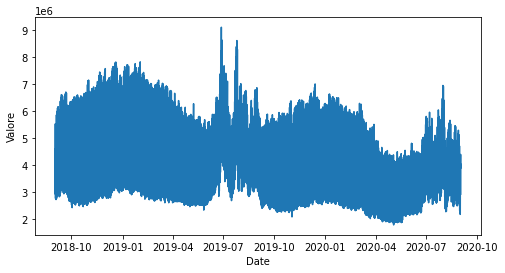

In [ ]:
plt.figure(figsize=(8,4))
plt.xlabel('Date')
plt.ylabel('Valore')
plt.plot(ts)

La serie storica mostra una stagionalità annuale da Ottobre a Giugno, con delle variazioni più alte che sembrano ripetersi nei mesi estivi. Si procede con delle visualizzazioni più dettagliate per una maggiore comprensione dei dati.

## Visualizzazioni dettagliate per periodo

In [ ]:
#dettaglio sui giorni della prima settimana
prima_settimana = ts.loc['2018-09-01':'2018-09-08']
prima_settimana

,VALORE
Datetime,
2018-09-01 01:00:00,3646742
2018-09-01 02:00:00,3273110
2018-09-01 03:00:00,3069245
2018-09-01 04:00:00,2969621
2018-09-01 05:00:00,2944116
...,...
2018-09-08 19:00:00,5015319
2018-09-08 20:00:00,5668002
2018-09-08 21:00:00,5754242


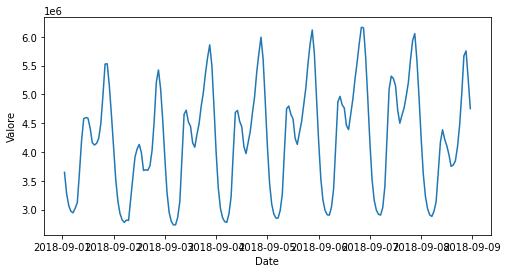

In [ ]:
plt.figure(figsize=(8,4))
plt.xlabel('Date')
plt.ylabel('Valore')
plt.plot(prima_settimana)

In [ ]:
#dettaglio su 3 mesi
tre_mesi = ts.loc['2018-09-01':'2018-12-01']
tre_mesi

,VALORE
Datetime,
2018-09-01 01:00:00,3646742
2018-09-01 02:00:00,3273110
2018-09-01 03:00:00,3069245
2018-09-01 04:00:00,2969621
2018-09-01 05:00:00,2944116
...,...
2018-12-01 19:00:00,6927150
2018-12-01 20:00:00,6915221
2018-12-01 21:00:00,6277600


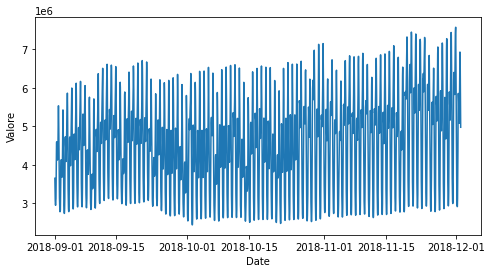

In [ ]:
plt.figure(figsize=(8,4))
plt.xlabel('Date')
plt.ylabel('Valore')
plt.plot(tre_mesi)

Questo grafico mostra chiaramente la presenza di una stagionalità settimanale.

In [ ]:
#focus estate '19
estate_19 = ts.loc['2019-06-01':'2019-09-01']
estate_19

,VALORE
Datetime,
2019-06-01 00:00:00,3943124
2019-06-01 01:00:00,3279456
2019-06-01 02:00:00,2928015
2019-06-01 03:00:00,2699974
2019-06-01 04:00:00,2607625
...,...
2019-09-01 19:00:00,5261467
2019-09-01 20:00:00,5811045
2019-09-01 21:00:00,6070463


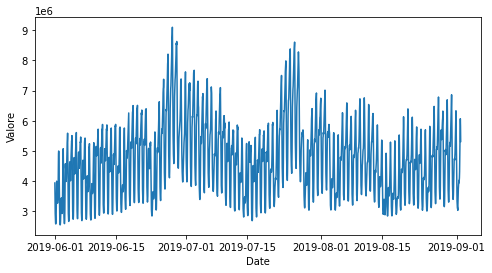

In [ ]:
plt.figure(figsize=(8,4))
plt.xlabel('Date')
plt.ylabel('Valore')
plt.plot(estate_19)

In [ ]:
estate_19.idxmax()

VALORE   2019-06-27 22:00:00
dtype: datetime64[ns]

#Test di stazionarietà

La distribuizione dei valori sembra seguire un comportamento normale, ma per valutare se sia necessario eseguire delle trasformazioni o differenziazioni della serie che ne garantiscano la stazionarietà, si eseguono i test di Dickey-Fuller e KPSS.

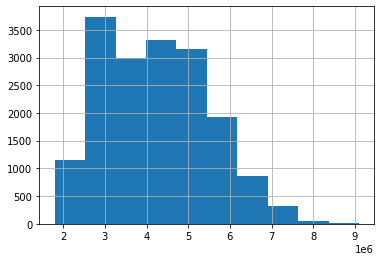

In [ ]:
ts['VALORE'].hist()

In [ ]:
X = ts['VALORE']
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


ADF Statistic: -5.491738
p-value: 0.000002
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [ ]:
dftest = kpss(ts, 'ct')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[3].items():
    print("\t{}: {}".format(k, v))


Test statistic = 0.964
P-value = 0.010
Critical values :
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


Poichè il test porta al rifiuto dell'ipotesi nulla per tutti i livelli di significatività non si effettuano trasformazioni della serie.

#Differenze con serie storica ritardata di un giorno (24 h)

In [ ]:
ts_lag = ts.diff(24).dropna()

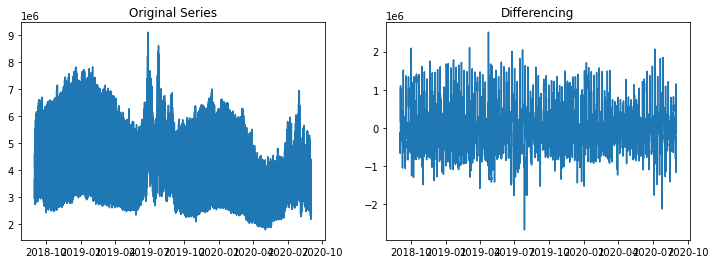

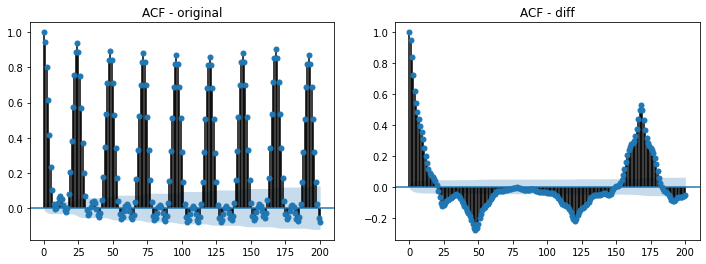

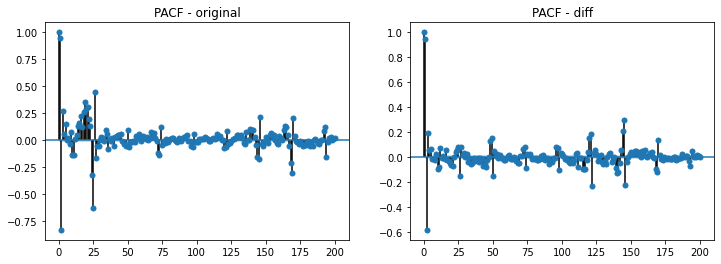

In [ ]:
plt.rcParams.update({'figure.figsize':(12,4)})
fig0, axes0 = plt.subplots(1, 2, sharex=True)
#Serie Originale
axes0[0].plot(ts['VALORE']); axes0[0].set_title('Original Series')
#Serie Differenziata
axes0[1].plot(ts_lag); axes0[1].set_title('Differencing')
plt.show()

#Serie Originale
fig1, axes1 = plt.subplots(1, 2, sharex=True)
plot_acf(ts, ax=axes1[0], lags=200); axes1[0].set_title('ACF - original')
#Serie Differenziata
plot_acf(ts_lag, ax=axes1[1], lags=200); axes1[1].set_title('ACF - diff')
plt.show()

#Serie Originale
fig2, axes2 = plt.subplots(1, 2, sharex=True)
plot_pacf(ts, ax=axes2[0], lags=200); axes2[0].set_title('PACF - original')
#Serie Differenziata
plot_pacf(ts_lag, ax=axes2[1], lags=200); axes2[1].set_title('PACF - diff')
plt.show()

I grafici ACF e PACF differenziati confermano la stagionalità settimanale e altri picchi, probabilmente causati da valori anomali.

#Divisione del dataset in Train e Validation

Per confrontare l'andamento dei modelli, si sceglie di dividere la serie disponibile in modo che gli ultimi due mesi siano la partizione di validation, ottenendo un train con circa l'82% delle osservazioni. 

In [ ]:
relativedelta(ts.index[-1],ts.index[0]) #range intero dataset

relativedelta(years=+1, months=+11, days=+30, hours=+23)

In [ ]:
train, test = ts.iloc[:16079].dropna(), ts.iloc[16079:] #il test sono gli ultimi due mesi

In [ ]:
test

,VALORE
Datetime,
2020-07-03 00:00:00,4265938
2020-07-03 01:00:00,3663311
2020-07-03 02:00:00,3268152
2020-07-03 03:00:00,3050300
2020-07-03 04:00:00,2950250
...,...
2020-08-31 20:00:00,4284919
2020-08-31 21:00:00,4400006
2020-08-31 22:00:00,3965396


#Modelli lineari

Lo studio inizia con lo sviluppo di modelli lineari, ARIMA ed UCM.

##Modelli ARIMA

Il primo modello, suggerito di correlogrammi è un ARIMA(3,0,1)(1,1,1) con m = 24.

### $ARIMA(3,0,1)(1,1,1)_{24}$



In [ ]:
mod = sm.tsa.statespace.SARIMAX(train['VALORE'], order=(3,0,1), seasonal_order=(1,1,1,24)) 
results = mod.fit()
print(results.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                             VALORE   No. Observations:                16080
Model:             SARIMAX(3, 0, 1)x(1, 1, 1, 24)   Log Likelihood             -208274.303
Date:                            Thu, 24 Dec 2020   AIC                         416562.606
Time:                                    12:40:33   BIC                         416616.393
Sample:                                         0   HQIC                        416580.393
                                          - 16080                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.0539      0.039     52.459      0.000       1.977       2.131
ar.L2         -1.4992      0.057   

In [ ]:
test.index

DatetimeIndex(['2020-07-03 01:00:00', '2020-07-03 02:00:00',
               '2020-07-03 03:00:00', '2020-07-03 04:00:00',
               '2020-07-03 05:00:00', '2020-07-03 06:00:00',
               '2020-07-03 07:00:00', '2020-07-03 08:00:00',
               '2020-07-03 09:00:00', '2020-07-03 10:00:00',
               ...
               '2020-08-31 15:00:00', '2020-08-31 16:00:00',
               '2020-08-31 17:00:00', '2020-08-31 18:00:00',
               '2020-08-31 19:00:00', '2020-08-31 20:00:00',
               '2020-08-31 21:00:00', '2020-08-31 22:00:00',
               '2020-08-31 23:00:00', '2020-09-01 00:00:00'],
              dtype='datetime64[ns]', name='Datetime', length=1440, freq=None)

In [ ]:
forecast = pd.DataFrame(results.predict(start = 16081, end= 17520 , dynamic= True)).set_index(test.index)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:1960: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  ' effect.', ValueWarning)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/kalman_filter.py:1960: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  ' effect.', ValueWarning)


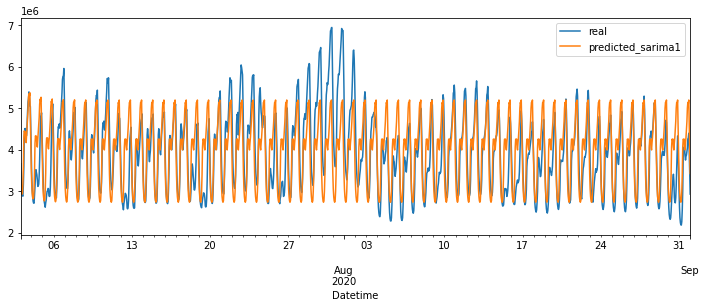

In [ ]:
forecast['predicted_sarima1'] = pd.DataFrame(results.predict(start = 16081, end= 17520 , dynamic= True)).set_index(test.index)
forecast['real'] = test['VALORE']
forecast[['real','predicted_sarima1']].plot()

Il modello coglie la stagionalità giornaliera ma successivamente non riesce ad adattarsi per la stagionalità settimanale. Quindi attraverso la funzione auto_arima(), si valuta se l'algoritmo riesce a trovare una combinazione di coefficienti con AIC minore e successivamente, attraverso Fourier, si crea un dataset con regressori dinamici da passare al modello come variabili endogene.

###Tentativi con funzione auto_arima()

In [ ]:
#!pip install pyramid-arima

     |████████████████████████████████| 604kB 7.9MB/s 


In [ ]:
stepwise_model_1 = auto_arima(train, start_p=0, start_q=0,
                           max_p=1, max_q=1, m=24,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/usr

Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 24); AIC=423555.089, BIC=423578.140, Fit time=49.099 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 24); AIC=426297.488, BIC=426312.855, Fit time=4.411 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 24); AIC=420326.018, BIC=420356.753, Fit time=73.156 seconds


In [ ]:
stepwise_model_2 = auto_arima(train, start_p=1, start_q=1,
                           max_p=2, max_q=2, m=24,
                           start_P=1, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model_2.aic())

Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 24); AIC=416630.493, BIC=416676.596, Fit time=165.305 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 24); AIC=426297.488, BIC=426312.855, Fit time=4.401 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 24); AIC=420326.018, BIC=420356.753, Fit time=72.877 seconds


In [ ]:
stepwise_model_3 = sm.tsa.statespace.SARIMAX(train['VALORE'], order=(2,1,1), seasonal_order=(1,1,1,24)) 
results = stepwise_model_3.fit()
print(results.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                             VALORE   No. Observations:                16080
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 24)   Log Likelihood             -207923.787
Date:                            Thu, 24 Dec 2020   AIC                         415859.574
Time:                                    11:02:43   BIC                         415905.676
Sample:                                         0   HQIC                        415874.819
                                          - 16080                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3050      0.012    111.032      0.000       1.282       1.328
ar.L2         -0.5437      0.006   

In [ ]:
stepwise_model_4 = sm.tsa.statespace.SARIMAX(train['VALORE'], order=(2,0,1), seasonal_order=(1,0,1,24)) 
results_stepwise_model_4 = stepwise_model_3.fit()
print(results_stepwise_model_4.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                             VALORE   No. Observations:                16080
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 24)   Log Likelihood             -207923.787
Date:                            Thu, 24 Dec 2020   AIC                         415859.574
Time:                                    11:34:40   BIC                         415905.676
Sample:                                         0   HQIC                        415874.819
                                          - 16080                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3050      0.012    111.032      0.000       1.282       1.328
ar.L2         -0.5437      0.006   

###Correzione stagionalità settimanale attraverso regressori dinamici

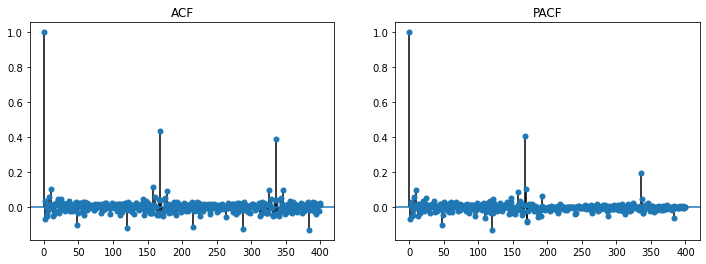

In [ ]:
acf_pacf_plot(results)

In [ ]:
#Creazione termini di Fourier
exog = pd.DataFrame({'date': ts.index})
exog = exog.set_index(pd.PeriodIndex(exog['date'], freq='H'))
exog['sin_week_2'] = np.sin(2 * np.pi * exog.index.hour / 168) #24*7
exog['cos_week_2'] = np.cos(2 * np.pi * exog.index.hour / 168) #24*7
exog['sin_year_4'] = np.sin(4 * np.pi * exog.index.hour / 8766) #24*365.25
exog['cos_year_4'] = np.cos(4 * np.pi * exog.index.hour / 8766)
exog = exog.drop(columns=['date'])
exog_to_train = exog.iloc[:(len(ts)-1441)]
exog_to_test = exog.iloc[(len(ts)-1441):]

In [ ]:
exog_to_train

,sin_week_2,cos_week_2,sin_year_4,cos_year_4
date,,,,
2018-09-01 01:00,0.037391,0.999301,0.001434,0.999999
2018-09-01 02:00,0.074730,0.997204,0.002867,0.999996
2018-09-01 03:00,0.111964,0.993712,0.004301,0.999991
2018-09-01 04:00,0.149042,0.988831,0.005734,0.999984
2018-09-01 05:00,0.185912,0.982566,0.007168,0.999974
...,...,...,...,...
2020-07-02 19:00,0.652287,0.757972,0.027234,0.999629
2020-07-02 20:00,0.680173,0.733052,0.028667,0.999589
2020-07-02 21:00,0.707107,0.707107,0.030100,0.999547


In [ ]:
mod = sm.tsa.statespace.SARIMAX(train['VALORE'], order=(3,0,1), seasonal_order=(1,1,1,24), 
                                exog = exog_to_train.values) 
results = mod.fit()
print(results.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                             VALORE   No. Observations:                16079
Model:             SARIMAX(3, 0, 1)x(1, 1, 1, 24)   Log Likelihood             -208261.749
Date:                            Wed, 30 Dec 2020   AIC                         416545.498
Time:                                    07:36:16   BIC                         416630.020
Sample:                                         0   HQIC                        416573.448
                                          - 16079                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -1.181e-05   1985.637  -5.95e-09      1.000   -3891.776    3891.776
x2          3.851e-05   1666.580   

In [ ]:
pred_val = pd.DataFrame(results.forecast(1441, exog = exog_to_test.values)).set_index(test.index)
pred_train = results.fittedvalues  


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


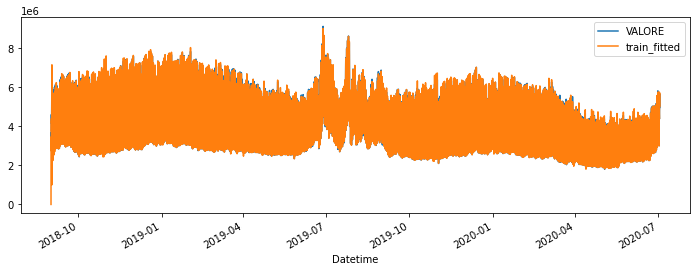

In [ ]:
train_viz = train
train_viz['train_fitted'] = pred_train
train_viz[['VALORE','train_fitted']].plot()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


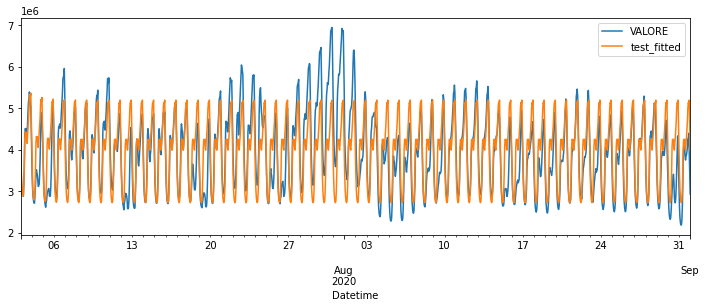

In [ ]:
test_viz = test
test_viz['test_fitted'] = pred_val
test_viz[['VALORE','test_fitted']].plot()

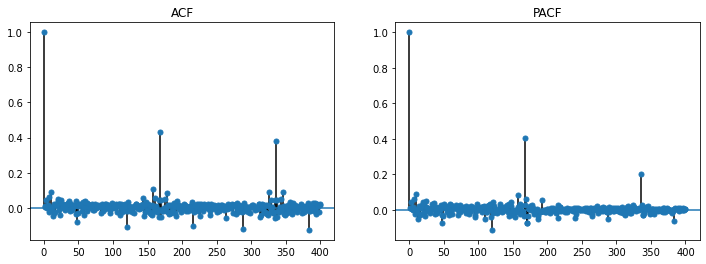

In [ ]:
acf_pacf_plot(results) 

Nonostante il calcolo di nuovi coefficienti, il modello ha prestazioni scarse e i grafici ACF e PACF non sembrano essere cambiati.

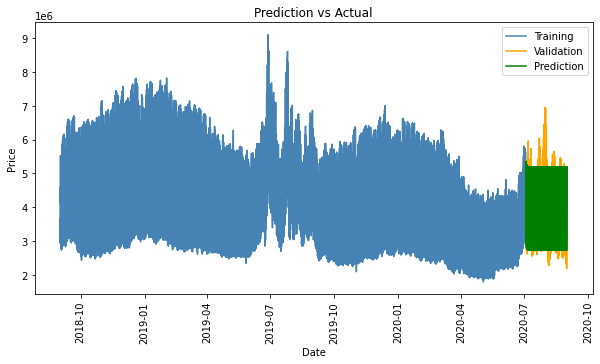

In [ ]:
#grafico intero
fig=plt.figure(figsize=(10,5))
fig.show()
ax=fig.add_subplot(111)
plt.title('Prediction vs Actual')
plt.xlabel('Date')
plt.ylabel('Valore')
plt.xticks(rotation=90)
ax.plot(train_viz['VALORE'], color='steelblue', label='Training')
#ax.plot(pred_mean_train[1:], color='red')
ax.plot(test_viz['VALORE'], color='orange', label='Validation')
ax.plot(test_viz['test_fitted'], color='green', label='Prediction')
plt.legend()
plt.show()

###Calcolo MAE per miglior modello ARIMA

In [ ]:
y_true_train = train_viz['VALORE']
y_pred_train = train_viz['train_fitted']
print(mean_absolute_error(y_true_train, y_pred_train))
y_true_test = test_viz['VALORE']
y_pred_test = test_viz['test_fitted']
print(mean_absolute_error(y_true_test, y_pred_test))

65574.99838464214
423848.5133111685


##UCM

Dopo la correzione della stagionalità, necessaria per alleggerire computazionalmente l'algoritmo e per cercare di far percepire al modello la stagionalità annuale, il modello migliore è risultato essere il seguente:
$Y_t = \mu_t + \gamma_t$, con stagionalità stocastica di tipo dummy con $s1$ = 24, stagionalità trigonometrica con $s2$ = 168. 

###Correzione stagionalità settimanale attraverso regressori dinamici

In [ ]:
#Creazione termini di Fourier
exog = pd.DataFrame({'date': ts.index})
exog = exog.set_index(pd.PeriodIndex(exog['date'], freq='H'))
exog['sin_year'] = np.sin(2 * np.pi * exog.index.hour / 8766) #24*365.25
exog['cos_year'] = np.cos(2 * np.pi * exog.index.hour / 8766) #24*365.25
exog = exog.drop(columns=['date'])
exog_to_train = exog.iloc[:(len(ts)-1441)]
exog_to_test = exog.iloc[(len(ts)-1441):]

In [ ]:
model_ucm = sm.tsa.UnobservedComponents(train, 'rwdrift',cycle = False, seasonal=24,
                                        freq_seasonal=[{'period': 168, 'harmonics': 20}],
                                        exog = exog_to_train.values)  
                                                  
model_ucm_fit = model_ucm.fit()
model_ucm_fit.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Unobserved Components Results                                 
===============================================================================================
Dep. Variable:                                  VALORE   No. Observations:                16079
Model:                          random walk with drift   Log Likelihood             -265453.202
                             + stochastic seasonal(24)   AIC                         530916.403
                   + stochastic freq_seasonal(168(20))   BIC                         530954.809
Date:                                 Thu, 31 Dec 2020   HQIC                        530929.105
Time:                                         09:20:57                                         
Sample:                                              0                                         
                                               - 16079                                         
Covariance Type:                                   opg                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
sigma2.level                  5.187e+11   4.22e+13      0.012      0.990   -8.22e+13    8.32e+13
sigma2.seasonal               3.801e+11   8.42e+12      0.045      0.964   -1.61e+13    1.69e+13
sigma2.freq_seasonal_168(20)  3.801e+11   2.59e+12      0.147      0.883   -4.69e+12    5.45e+12
beta.x1                       1.526e+08    3.2e+09      0.048      0.962   -6.11e+09    6.42e+09
beta.x2                      -1.258e+06    3.7e+08     -0.003      0.997   -7.27e+08    7.24e+08
===================================================================================
Ljung-Box (Q):                     8499.82   Jarque-Bera (JB):             13768.08
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.58   Skew:                             0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
#model_ucm_fit.save("model_ucm_fit.pickle")

###Componenti UCM

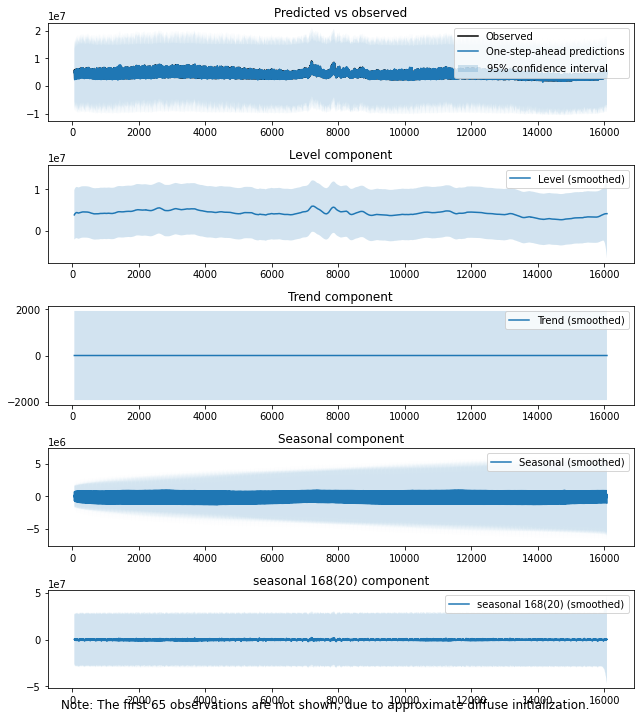

In [ ]:
fig = model_ucm_fit.plot_components(figsize=(9, 10))
fig.tight_layout()

In [ ]:
pred_val = pd.DataFrame(model_ucm_fit.forecast(1441, exog = exog_to_test.values)).set_index(test.index)
pred_train = model_ucm_fit.fittedvalues  

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


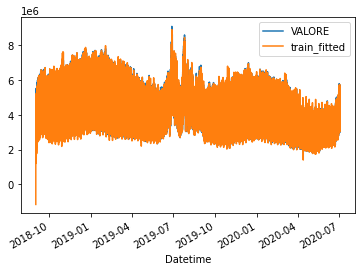

In [ ]:
train_viz = train
train_viz['train_fitted'] = pred_train
train_viz[['VALORE','train_fitted']].plot()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


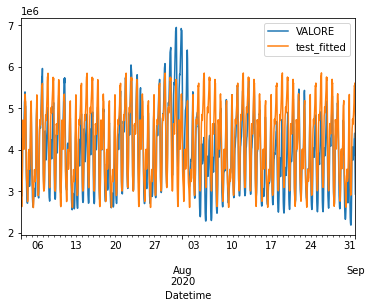

In [ ]:
test_viz = test
test_viz['test_fitted'] = pred_val
test_viz[['VALORE','test_fitted']].plot()

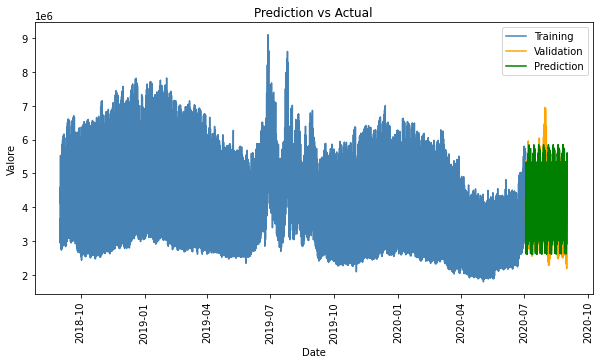

In [ ]:
#grafico intero
fig=plt.figure(figsize=(10,5))
fig.show()
ax=fig.add_subplot(111)
plt.title('Prediction vs Actual')
plt.xlabel('Date')
plt.ylabel('Valore')
plt.xticks(rotation=90)
ax.plot(train_viz['VALORE'], color='steelblue', label='Training')
#ax.plot(pred_mean_train[1:], color='red')
ax.plot(test_viz['VALORE'], color='orange', label='Validation')
ax.plot(test_viz['test_fitted'], color='green', label='Prediction')
plt.legend()
plt.show()

###Calcolo MAE per miglior modello UCM

In [ ]:
y_true_train = train_viz['VALORE']
y_pred_train = train_viz['train_fitted']
print(mean_absolute_error(y_true_train, y_pred_train))
y_true_test = test_viz['VALORE']
y_pred_test = test_viz['test_fitted']
print(mean_absolute_error(y_true_test, y_pred_test))

98225.74746402507
450642.1986767746


Nonostante gli UCM mostrano un comportamento visivamente più corretto, in quanto la stagionalità settimanale è stata modellata correttamente attraverso la forma trigonometrica, hanno errore medio assoluto maggiore rispetto gli ARIMA. 

#Modelli non lineari

Il primo approccio ai modelli non lineari, è stato model-free, utilizzando knn.

##KNN

Poichè Python non presenta una libreria ottimizzata per la costruzione di modelli knn per l'approccio Time-Series, è stata utilizzata la libreria $tsfknn$ in R.




In [ ]:
%%R
data <- read.csv('TrainingSet.csv', sep = ';')
ts <- data$VALORE

In [ ]:
%%R
t <- 16079
p <- 1:168 
k <- c(3,5,7,9) 
h <- 1439 

###Variazioni del MAE per diversi valori di k

Dopo aver impostato i parametri per la previsione ricorsiva, si è valutato il valore adatto di k a seconda della variazione del valore medio assoluto

In [ ]:
%%R
for (i in c(1:4)){
    res <- knn_forecasting( timeS=ts[1:t], h=h, lags=p, k=i, msas="recursive", cf="mean" )
    print(mae(res$prediction , ts[(t+1):(t+h)]))
}
#k = 9 MAE sul test minore

[1] 1163271
[1] 805111.1
[1] 729823
[1] 678972.1


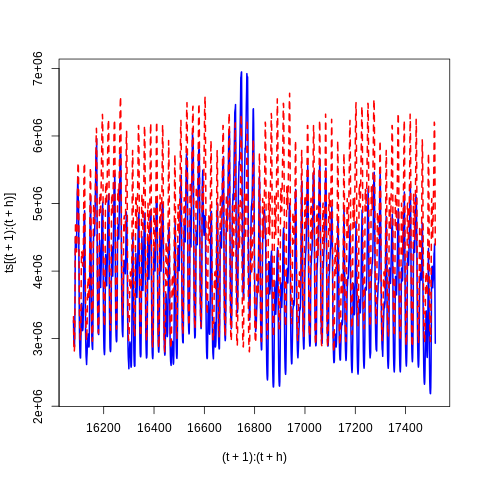

In [ ]:
%%R
#plot( c(ts[(t+1):(t+h)],numeric(h)+NA), type="l", lwd=2 )
plot( (t+1):(t+h), ts[(t+1):(t+h)], lwd=2, type='l' , col = 'blue')
lines( (t+1):(t+h), res$prediction, lty=2, lwd=2, col="red" )


##RNN

Per l'approccio RNN è necessario reimpostare il dataset selezionando un periodo di lookback per addestrare la rete. Inizialmente si lanciano due modelli (LSTM e GRU) con un valore pari a 24 (giornaliero) per un'analisi iniziale.

###Normalizzazione e creazione delle partizioni per le reti neurali 

In [ ]:
#Normalizzazione del dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(ts)

In [ ]:
train, test = dataset[0:16079,:], dataset[16079:len(dataset),:]
print(len(train), len(test))

16079 1441


In [ ]:
#Rilanciare per ogni tentativo di rnn per cambiare lookback
look_back = 24
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
#Ristrutturazione del dataset
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

###LSTM

In [ ]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)

Epoch 1/10
16077/16077 - 16s - loss: 0.0052
Epoch 2/10
16077/16077 - 14s - loss: 0.0034
Epoch 3/10
16077/16077 - 14s - loss: 0.0034
Epoch 4/10
16077/16077 - 14s - loss: 0.0034
Epoch 5/10
16077/16077 - 14s - loss: 0.0034
Epoch 6/10
16077/16077 - 14s - loss: 0.0034
Epoch 7/10
16077/16077 - 14s - loss: 0.0034
Epoch 8/10
16077/16077 - 14s - loss: 0.0034
Epoch 9/10
16077/16077 - 14s - loss: 0.0034
Epoch 10/10
16077/16077 - 14s - loss: 0.0034


In [ ]:
trainY

array([0.20219384, 0.17427857, 0.16063704, ..., 0.52702892, 0.51742984,
       0.52357746])

In [ ]:
#Previsioni 
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
#Previsioni scalate
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
#Calcolo MAE
trainScore = mean_absolute_error(trainY[0], trainPredict[:,0])
print('Train Score: %.2f MAE' % (trainScore))
testScore = mean_absolute_error(testY[0], testPredict[:,0])
print('Test Score: %.2f MAE' % (testScore))

Train Score: 340446.64 MAE
Test Score: 239332.54 MAE


In [ ]:
testY

array([[3663311., 3268152., 3050300., ..., 4400006., 3965396., 3442262.]])

In [ ]:
testPredict

array([[4212116.5],
       [3641995. ],
       [3271978. ],
       ...,
       [4230115. ],
       [4339231.5],
       [3927293.2]], dtype=float32)

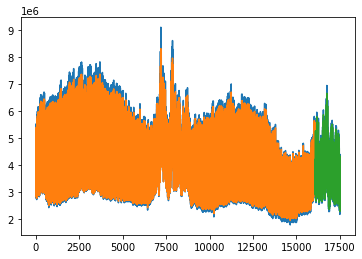

In [ ]:
#Previsioni train per grafico
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
#Previsioni test per grafico
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
#Grafico intero
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

###GRU

In [ ]:
from keras.layers import GRU

In [ ]:
model = Sequential()
model.add(GRU(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)

Epoch 1/10
16077/16077 - 16s - loss: 0.0056
Epoch 2/10
16077/16077 - 15s - loss: 0.0034
Epoch 3/10
16077/16077 - 15s - loss: 0.0034
Epoch 4/10
16077/16077 - 15s - loss: 0.0035
Epoch 5/10
16077/16077 - 15s - loss: 0.0034
Epoch 6/10
16077/16077 - 15s - loss: 0.0034
Epoch 7/10
16077/16077 - 15s - loss: 0.0034
Epoch 8/10
16077/16077 - 15s - loss: 0.0034
Epoch 9/10
16077/16077 - 15s - loss: 0.0034
Epoch 10/10
16077/16077 - 15s - loss: 0.0034


In [ ]:
#Previsioni
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
#Previsioni scalate
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
#Calcolo MAE
trainScore = mean_absolute_error(trainY[0], trainPredict[:,0])
print('Train Score: %.2f MAE' % (trainScore))
testScore = mean_absolute_error(testY[0], testPredict[:,0])
print('Test Score: %.2f MAE' % (testScore))

Train Score: 339868.07 MAE
Test Score: 236353.38 MAE


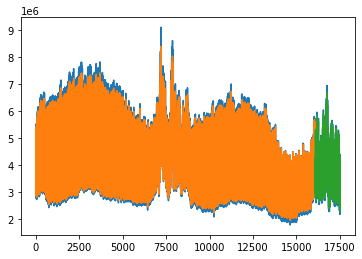

In [ ]:
#Previsioni train per grafico
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
#Previsioni test per grafico
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
#Grafico intero
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

###Cambio periodo di Look-Back e unità

Dopo diverse prove, l'architettura migliore è risultata una RNN con un layer LSTM con 256 Neuroni, addestrata su 15 epoche e batch_size = 16.

In [ ]:
#Cambio di lookback --> rilanciare create_dataset
#look_back = 168

In [ ]:
early_stop = EarlyStopping(monitor = 'loss', patience = 2)
model = Sequential()
model.add(LSTM(256, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=15, batch_size=16, verbose=1, callbacks = [early_stop])

Epoch 1/15
995/995 [==============================] - 10s 3ms/step - loss: 0.0048
Epoch 2/15
995/995 [==============================] - 3s 3ms/step - loss: 9.4675e-04
Epoch 3/15
995/995 [==============================] - 3s 3ms/step - loss: 7.7289e-04
Epoch 4/15
995/995 [==============================] - 3s 3ms/step - loss: 5.9166e-04
Epoch 5/15
995/995 [==============================] - 3s 3ms/step - loss: 5.0561e-04
Epoch 6/15
995/995 [==============================] - 3s 3ms/step - loss: 5.0321e-04
Epoch 7/15
995/995 [==============================] - 3s 3ms/step - loss: 3.9521e-04
Epoch 8/15
995/995 [==============================] - 3s 3ms/step - loss: 4.5189e-04
Epoch 9/15
995/995 [==============================] - 3s 3ms/step - loss: 3.7479e-04
Epoch 10/15
995/995 [==============================] - 3s 3ms/step - loss: 3.6238e-04
Epoch 11/15
995/995 [==============================] - 3s 3ms/step - loss: 3.7537e-04
Epoch 12/15
995/995 [==============================] - 3s 3ms/step

In [ ]:
#Previsioni
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
#Previsioni scalate
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
#Calcolo MAE
trainScore = mean_absolute_error(trainY[0], trainPredict[:,0])
print('Train Score: %.2f MAE' % (trainScore))
testScore = mean_absolute_error(testY[0], testPredict[:,0])
print('Test Score: %.2f MAE' % (testScore))

Train Score: 91761.41 MAE
Test Score: 89607.71 MAE


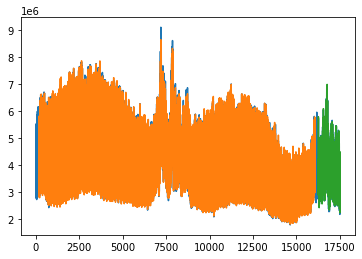

In [ ]:
#Previsioni train per grafico
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
#Previsioni test per grafico
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
#Grafico intero
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

#Tabella con MAE 

In [ ]:
mae_table = pd.DataFrame({'train_mae': [65574.998, 98225.747, 91761.41], 
                          'test_mae': [423848.513, 450642.199, 89607.71]},
                         index = ['Arima','UCM','ML'])
mae_table

,train_mae,test_mae
Arima,65574.998,423848.513
UCM,98225.747,450642.199
ML,91761.410,89607.710


#Previsioni orarie del valore dal 2020-09-01 al 2020-10-31 

Determinati tutti i modelli richiesti, si procede con la previsione per i 2 mesi sconosciuti. Quindi si creano gli indici per la creazione del test set e dei regressori di Fourier.

In [ ]:
test_datetime = pd.date_range(start='2020-09-01', end='2020-11-01', freq ='H')[1:]
date_fourier = pd.date_range(start='2018-09-01', end='2020-11-01', freq ='H')

In [ ]:
df_fourier = pd.DataFrame(index=date_fourier)

##Arima

In [ ]:
#Creazione termini di Fourier
exog = pd.DataFrame({'date': df_fourier.index})
exog = exog.set_index(pd.PeriodIndex(exog['date'], freq='H'))
exog['sin_week_2'] = np.sin(2 * np.pi * exog.index.hour / 168) #24*7
exog['cos_week_2'] = np.cos(2 * np.pi * exog.index.hour / 168) #24*7
exog['sin_year_4'] = np.sin(4 * np.pi * exog.index.hour / 8766) #24*365.25
exog['cos_year_4'] = np.cos(4 * np.pi * exog.index.hour / 8766) #24*365.25
exog = exog.drop(columns=['date'])

exog_to_train = exog[:len(ts)]
exog_to_test = exog['2020-09-01 01:00:00':]

In [ ]:
mod = sm.tsa.statespace.SARIMAX(ts['VALORE'], order=(3,0,1), seasonal_order=(1,1,1,24), 
                                exog = exog_to_train.values) 
results = mod.fit()
print(results.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                             VALORE   No. Observations:                17520
Model:             SARIMAX(3, 0, 1)x(1, 1, 1, 24)   Log Likelihood             -226744.563
Date:                            Wed, 30 Dec 2020   AIC                         453511.126
Time:                                    09:06:25   BIC                         453596.593
Sample:                                         0   HQIC                        453539.271
                                          - 17520                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1           2.85e-05   1801.303   1.58e-08      1.000   -3530.489    3530.489
x2          2.383e-05   1751.739   

In [ ]:
pred_val = results.forecast(1464, exog=exog_to_test)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [ ]:
data_fitted = pd.DataFrame(pred_val).set_index(test_datetime)
data_fitted.to_csv('/content/gdrive/MyDrive/sdmtsa/data_fitted.csv')

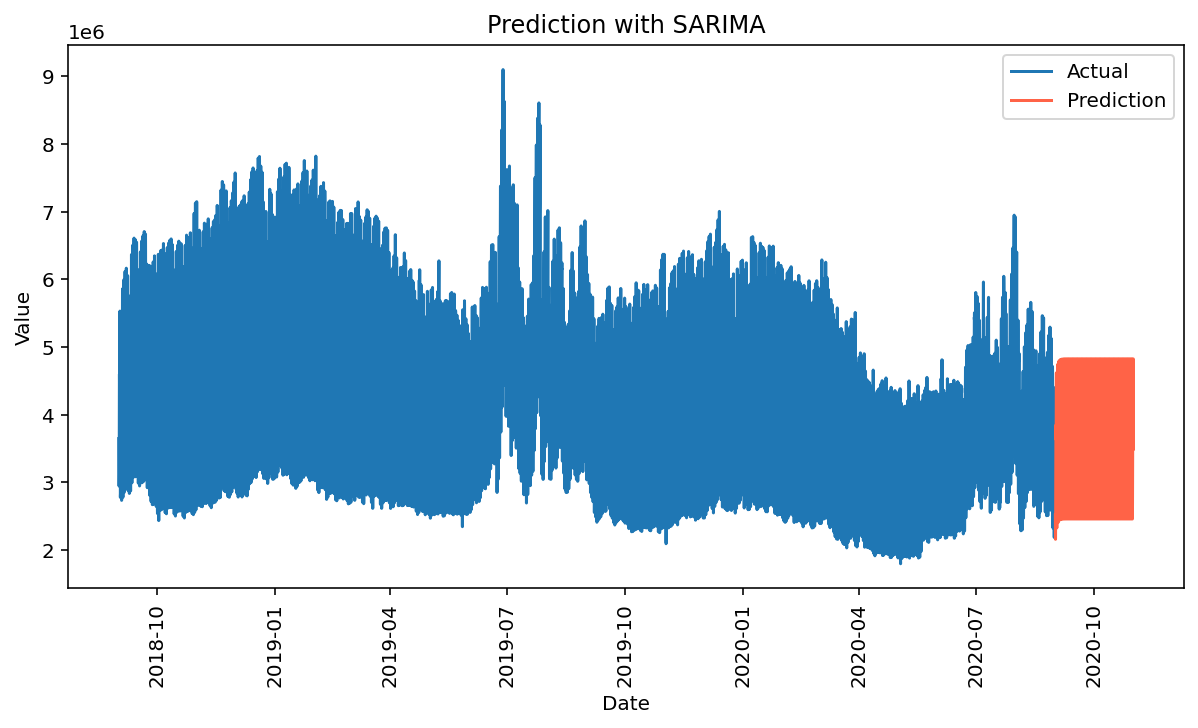

In [ ]:
fig=plt.figure(figsize=(10,5))
fig.show()
ax=fig.add_subplot(111)


plt.title('Prediction with SARIMA')
plt.xlabel('Date')
plt.ylabel('Value')
plt.xticks(rotation=90)
ax.plot(ts, label='Actual')
ax.plot(data_fitted, color='tomato', label='Prediction')
plt.legend()
plt.show()

##UCM

In [ ]:
#Creazione termini di Fourier
exog = pd.DataFrame({'date': df_fourier.index})
exog = exog.set_index(pd.PeriodIndex(exog['date'], freq='H'))
exog['sin_year_2'] = np.sin(2 * np.pi * exog.index.hour / 8766) #24*365.25
exog['cos_year_2'] = np.cos(2 * np.pi * exog.index.hour / 8766)
exog['sin_year_4'] = np.sin(4 * np.pi * exog.index.hour / 8766) 
exog['cos_year_4'] = np.cos(4 * np.pi * exog.index.hour / 8766)
exog = exog.drop(columns=['date'])

exog_to_train = exog[:len(ts)]
exog_to_test = exog['2020-09-01 01:00:00':]

In [ ]:
model_ucm = sm.tsa.UnobservedComponents(ts['VALORE'], 'rwdrift', cycle = False, seasonal=24,
                                        freq_seasonal=[{'period': 168, 'harmonics': 20}],
                                        exog = exog_to_train.values)  
                                                  
model_ucm_fit = model_ucm.fit(low_memory = True)
model_ucm_fit.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Unobserved Components Results                                 
===============================================================================================
Dep. Variable:                                  VALORE   No. Observations:                17520
Model:                          random walk with drift   Log Likelihood             -287825.365
                             + stochastic seasonal(24)   AIC                         575664.731
                   + stochastic freq_seasonal(168(20))   BIC                         575719.102
Date:                                 Wed, 30 Dec 2020   HQIC                        575682.637
Time:                                         10:05:44                                         
Sample:                                              0                                         
                                               - 17520                                         
Covariance Type:                                   opg                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
sigma2.level                  5.044e+11   3.75e+13      0.013      0.989    -7.3e+13     7.4e+13
sigma2.seasonal               3.177e+11   7.41e+12      0.043      0.966   -1.42e+13    1.48e+13
sigma2.freq_seasonal_168(20)  3.177e+11   2.24e+12      0.142      0.887   -4.08e+12    4.72e+12
beta.x1                      -4.619e+12   1.39e+15     -0.003      0.997   -2.72e+15    2.71e+15
beta.x2                       3.079e+10   1.09e+13      0.003      0.998   -2.14e+13    2.14e+13
beta.x3                        2.31e+12   6.93e+14      0.003      0.997   -1.36e+15    1.36e+15
beta.x4                      -3.079e+10   1.09e+13     -0.003      0.998   -2.14e+13    2.14e+13
===================================================================================
Ljung-Box (Q):                     9401.88   Jarque-Bera (JB):             10528.20
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.57   Skew:                             0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
pred_val = model_ucm_fit.forecast(1464, exog=exog_to_test)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [ ]:
pd.DataFrame(pred_val).set_index(test_datetime)

17520    2.487833e+06
17521    2.307908e+06
17522    2.308460e+06
17523    2.399452e+06
17524    2.516104e+06
             ...     
18979    4.428314e+06
18980    4.483830e+06
18981    4.024574e+06
18982    3.521020e+06
18983    1.878180e+06
Length: 1464, dtype: float64

In [ ]:
data_fitted = pd.read_csv('/content/gdrive/MyDrive/sdmtsa/data_fitted.csv')
data_fitted

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,0,UCM
0,2020-09-01 01:00:00,0,2020-09-01 01:00:00,2.518004e+06,2.487833e+06
1,2020-09-01 02:00:00,1,2020-09-01 02:00:00,2.285654e+06,2.307908e+06
2,2020-09-01 03:00:00,2,2020-09-01 03:00:00,2.190162e+06,2.308460e+06
3,2020-09-01 04:00:00,3,2020-09-01 04:00:00,2.158036e+06,2.399452e+06
4,2020-09-01 05:00:00,4,2020-09-01 05:00:00,2.163738e+06,2.516104e+06
...,...,...,...,...,...
1459,2020-10-31 20:00:00,1459,2020-10-31 20:00:00,4.683425e+06,4.428314e+06
1460,2020-10-31 21:00:00,1460,2020-10-31 21:00:00,4.824078e+06,4.483830e+06
1461,2020-10-31 22:00:00,1461,2020-10-31 22:00:00,4.486344e+06,4.024574e+06
1462,2020-10-31 23:00:00,1462,2020-10-31 23:00:00,4.009470e+06,3.521020e+06


In [ ]:
data_fitted['UCM'] = pd.DataFrame(pred_val).set_index(test_datetime)
data_fitted.to_csv('/content/gdrive/MyDrive/sdmtsa/data_fitted.csv')

In [ ]:
data_fitted = data_fitted[['0','UCM']].set_index(test_datetime)
data_fitted

,0,UCM
2020-09-01 01:00:00,2.518004e+06,2.487833e+06
2020-09-01 02:00:00,2.285654e+06,2.307908e+06
2020-09-01 03:00:00,2.190162e+06,2.308460e+06
2020-09-01 04:00:00,2.158036e+06,2.399452e+06
2020-09-01 05:00:00,2.163738e+06,2.516104e+06
...,...,...
2020-10-31 20:00:00,4.683425e+06,4.428314e+06
2020-10-31 21:00:00,4.824078e+06,4.483830e+06
2020-10-31 22:00:00,4.486344e+06,4.024574e+06
2020-10-31 23:00:00,4.009470e+06,3.521020e+06


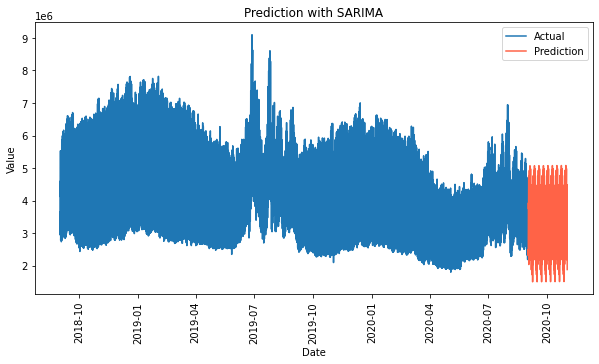

In [ ]:
fig=plt.figure(figsize=(10,5))
fig.show()
ax=fig.add_subplot(111)


plt.title('Prediction with UCM')
plt.xlabel('Date')
plt.ylabel('Value')
plt.xticks(rotation=90)
ax.plot(ts, label='Actual')
ax.plot(data_fitted['UCM'], color='tomato', label='Prediction')
plt.legend()
plt.show()

In [ ]:
data_fitted.to_csv('/content/gdrive/MyDrive/sdmtsa/data_fitted.csv')

##ML

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(ts)

In [ ]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
train = dataset

In [ ]:
look_back = 168

In [ ]:
trainX, trainY = create_dataset(train, look_back)

In [ ]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))

In [ ]:
model = Sequential()
model.add(LSTM(256, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=15, batch_size=16, verbose=1)

Epoch 1/15
1085/1085 [==============================] - 9s 7ms/step - loss: 0.0050
Epoch 2/15
1085/1085 [==============================] - 8s 7ms/step - loss: 7.5699e-04
Epoch 3/15
1085/1085 [==============================] - 8s 7ms/step - loss: 6.9528e-04
Epoch 4/15
1085/1085 [==============================] - 8s 7ms/step - loss: 5.7348e-04
Epoch 5/15
1085/1085 [==============================] - 8s 7ms/step - loss: 5.0671e-04
Epoch 6/15
1085/1085 [==============================] - 8s 7ms/step - loss: 4.0300e-04
Epoch 7/15
1085/1085 [==============================] - 8s 7ms/step - loss: 4.5488e-04
Epoch 8/15
1085/1085 [==============================] - 8s 7ms/step - loss: 4.1344e-04
Epoch 9/15
1085/1085 [==============================] - 8s 7ms/step - loss: 3.5602e-04
Epoch 10/15
1085/1085 [==============================] - 8s 7ms/step - loss: 3.3337e-04
Epoch 11/15
1085/1085 [==============================] - 8s 7ms/step - loss: 3.4234e-04
Epoch 12/15
1085/1085 [======================

Dopo aver addestrato la rete neurale su tutti i dati disponibili, per calcolare la previsione è necessario implementare una funzione che crei previsioni ricorsivamente.

In [ ]:
num_prediction = len(test_datetime)
forecast = predict(num_prediction, model)

In [ ]:
forecast = scaler.inverse_transform(forecast.reshape(-1,1)).flatten()
forecast = pd.DataFrame(forecast[0:1464], index = test_datetime)

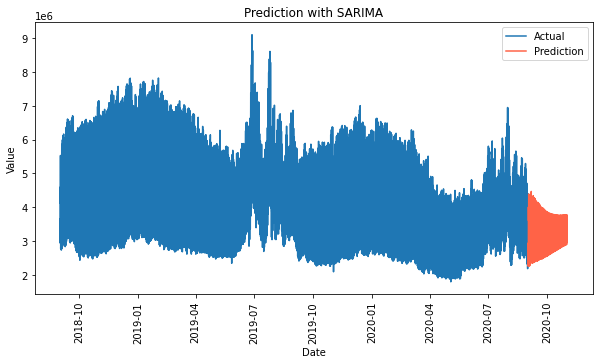

In [ ]:
fig=plt.figure(figsize=(10,5))
fig.show()
ax=fig.add_subplot(111)


plt.title('Prediction with LSTM')
plt.xlabel('Date')
plt.ylabel('Value')
plt.xticks(rotation=90)
ax.plot(ts, label='Actual')
ax.plot(forecast, color='tomato', label='Prediction')
plt.legend()
plt.show()

In [ ]:
data_fitted = pd.read_csv('/content/gdrive/MyDrive/sdmtsa/data_fitted.csv')
data_fitted = data_fitted.set_index(test_datetime) 

In [ ]:
data_fitted['ML'] = forecast

#Esportazione csv 

Ottenuti i vettori con le previsioni per i 3 modelli migliori secondo la metrica del MAE, si esporta il file finale con gli indici temporali a livello orario.

In [ ]:
data_fitted = data_fitted.rename(columns={'0':'ARIMA'})

In [ ]:
data_fitted = data_fitted[['ARIMA','UCM','ML']]

In [ ]:
data_fitted

,ARIMA,UCM,ML
2020-09-01 01:00:00,2.518004e+06,2.487833e+06,2.932544e+06
2020-09-01 02:00:00,2.285654e+06,2.307908e+06,2.586042e+06
2020-09-01 03:00:00,2.190162e+06,2.308460e+06,2.375566e+06
2020-09-01 04:00:00,2.158036e+06,2.399452e+06,2.272242e+06
2020-09-01 05:00:00,2.163738e+06,2.516104e+06,2.256916e+06
...,...,...,...
2020-10-31 20:00:00,4.683425e+06,4.428314e+06,3.424521e+06
2020-10-31 21:00:00,4.824078e+06,4.483830e+06,3.298390e+06
2020-10-31 22:00:00,4.486344e+06,4.024574e+06,3.171010e+06
2020-10-31 23:00:00,4.009470e+06,3.521020e+06,3.058747e+06


In [ ]:
data_fitted['Ora'] = data_fitted.index.hour
data_fitted['Ora'] = data_fitted['Ora'].replace(0,24)

In [ ]:
data_fitted['Data'] = data_fitted.index.date

In [ ]:
#Cambio formato indice e trasformazione ora 00 in 24
list_new_date = []

for index, row in data_fitted.iterrows():
  if row['Ora'] == 24:
    list_new_date.append(row['Data'] - timedelta(days=1))
  else:
    list_new_date.append(row['Data'])


In [ ]:
data_fitted['Data'] = list_new_date

In [ ]:
data_fitted = data_fitted.reset_index(drop = True)

In [ ]:
data_fitted

,ARIMA,UCM,ML,Ora,Data
0,2.518004e+06,2.487833e+06,2.932544e+06,1,2020-09-01
1,2.285654e+06,2.307908e+06,2.586042e+06,2,2020-09-01
2,2.190162e+06,2.308460e+06,2.375566e+06,3,2020-09-01
3,2.158036e+06,2.399452e+06,2.272242e+06,4,2020-09-01
4,2.163738e+06,2.516104e+06,2.256916e+06,5,2020-09-01
...,...,...,...,...,...
1459,4.683425e+06,4.428314e+06,3.424521e+06,20,2020-10-31
1460,4.824078e+06,4.483830e+06,3.298390e+06,21,2020-10-31
1461,4.486344e+06,4.024574e+06,3.171010e+06,22,2020-10-31
1462,4.009470e+06,3.521020e+06,3.058747e+06,23,2020-10-31


In [ ]:
data_fitted.to_csv('/content/gdrive/MyDrive/sdmtsa/data_fitted.csv',
                   sep = ';',
                   columns = ['Data','Ora','ARIMA','UCM','ML'],
                   index = False)